In [3]:
from __future__ import print_function
import hoomd
from hoomd import hpmc
from hoomd import deprecated
#import ex_render
from matplotlib import pyplot
import numpy
import sys
import scipy
%matplotlib inline

# Goal

The goal of this exercise is to find the highest packing fraction possible for hard tetrahedrons where "hard" implies that the particles should not overlap each other.

# Strategy

The strategy used here is to use a Metropolis Monte Carlo (MC) algorithm to place the hard tetrahedrons in a cubic volume. A quick compression scheme is used in conjuction with the MC algorithm to achieve this goal. We use a MC code called [HOOMD](http://hoomd-blue.readthedocs.io/en/stable/index.html) because of its ease of use and performance benefits.

### Quick compression scheme

You can compress a system from a random dilute configuration to a high packing fraction quickly by forcing the system volume to compress. This generates small overlaps between particles. Perform trial moves until all of the overlaps are gone. Repeat this process until it reaches the desired packing fraction. Note that the particles positions are simply scaled according to the box voume update.

### Initial condition

The initial condition is a random placement of tetrahedrons at low packing fraction of 0.1. These tetrahedrons all have the same rotation to start with. We start with a small number of particles ($N=100$)

### Packing fraction calculation

Packing fraction is calculated as $\phi = \frac{N~V_p}{V_c}$ where $\phi$ is the packing fraction, $N$ is the number of tetrahedrons, $V_p$ is the volume of the terahedron and $V_c$ is the volume of the cell. Below we first calculate $V_p$ to be 0.333 $\sigma^3$

In [4]:
import math
tetrahedron_side = math.sqrt(2)
tetrahedron_volume = tetrahedron_side**3/(6*math.sqrt(2))
tetrahedron_volume

0.33333333333333337

 Here we initialize HOOMD, create the initial condition and perform some MC trial moves to verify that the simulation parameters works fine.

In [5]:
hoomd.context.initialize('--mode=cpu');
#system = hoomd.init.create_lattice(unitcell=hoomd.lattice.fcc(a=3.2), n=[5, 5,5]);
system=deprecated.init.create_random(N=100, phi_p=0.1, min_dist=1.0)

initial_Ly = system.box.Ly;
mc = hoomd.hpmc.integrate.convex_polyhedron(seed=415236, d=0.3, a=0.4)
tetrahedron_verts = [(0.5, 0.5, 0.5), (0.5, -0.5, -0.5), (-0.5, 0.5, -0.5), (-0.5, -0.5, 0.5)]
mc.shape_param.set('A',vertices=tetrahedron_verts);
d = hoomd.dump.gsd("trajectory.gsd",
                   period=10,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(1000);

HOOMD-blue 2.2.2-unknown DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 12/04/17
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 100 particles
** starting run **
Time 00:00:00 | Step 1000 / 1000 | T

*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


The acceptance rate for translation moves and rotational moves are around 80 %. In moderately dense to sense systems, optimal move size ($d$ and $a$) is chosen such that the acceptance rate is around 20 %. 

As a first step, we increase the initial packing fraction from 0.1 to 0.3 in steps of 0.01 and find the limit.

In [6]:
import numpy as np
try:
    for init_density in np.arange(0.1,0.31,0.01):
        print('trying density of ',init_density)
        hoomd.context.initialize('--mode=cpu');
        #system = hoomd.init.create_lattice(unitcell=hoomd.lattice.fcc(a=3.2), n=[5, 5,5]);
        system=deprecated.init.create_random(N=100, phi_p=init_density, min_dist=1.0)

        initial_Ly = system.box.Ly;
        mc = hoomd.hpmc.integrate.convex_polyhedron(seed=415236, d=0.3, a=0.4)
        tetrahedron_verts = [(0.5, 0.5, 0.5), (0.5, -0.5, -0.5), (-0.5, 0.5, -0.5), (-0.5, -0.5, 0.5)]
        mc.shape_param.set('A',vertices=tetrahedron_verts);
        d = hoomd.dump.gsd("trajectory.gsd",
                           period=10,
                           group=hoomd.group.all(),
                           overwrite=True);
        hoomd.run(1000,quiet=True);
except RuntimeError:
    print('Error while trying density of ',init_density)

trying density of  0.1
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.11
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.12
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.13
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.13999999999999999
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.14999999999999997
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.15999999999999998
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.16999999999999998
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.17999999999999997
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.18999999999999995
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.19999999999999996
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.20999999999999996
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.21999999999999995
notice(2): Group "all" created containing 100 particles


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.
*

trying density of  0.22999999999999995
notice(2): Group "all" created containing 100 particles


Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


trying density of  0.23999999999999994
notice(2): Group "all" created containing 100 particles
trying density of  0.24999999999999992
Error while trying density of  0.24999999999999992


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.
**ERROR**: 
The polymer generator failed to place a polymer, the system is too dense or the separation radii are set too high



From the log above, it is clear that the highest initial packing fraction for this system is 0.24. 

In [7]:
hoomd.context.initialize('--mode=cpu');
#system = hoomd.init.create_lattice(unitcell=hoomd.lattice.fcc(a=3.2), n=[5, 5,5]);
system=deprecated.init.create_random(N=100, phi_p=0.24, min_dist=1.0)

initial_Ly = system.box.Ly;
mc = hoomd.hpmc.integrate.convex_polyhedron(seed=415236, d=0.3, a=0.4)
tetrahedron_verts = [(0.5, 0.5, 0.5), (0.5, -0.5, -0.5), (-0.5, 0.5, -0.5), (-0.5, -0.5, 0.5)]
mc.shape_param.set('A',vertices=tetrahedron_verts);
d = hoomd.dump.gsd("trajectory.gsd",
                   period=10,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(1000,quiet=False);

notice(2): Group "all" created containing 100 particles
** starting run **
Time 00:00:01 | Step 1000 / 1000 | TPS 988.879 | ETA 00:00:00
Average TPS: 988.31
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.4348
notice(2): Average rotate acceptance:    0.409327
notice(2): Trial moves per second:        395041
notice(2): Overlap checks per second:     2.44995e+07
notice(2): Overlap checks per trial move: 62.0176
notice(2): Number of overlap errors:      0
** run complete **


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 33 images per trial move, performance may slow.
This message will not be repeated.


Now the acceptance rate is about 40 %. We can further fine tune the acceptance rate using the parameter tuner feature in HOOMD. Below we try to change $d$(translation move size) and $a$(roational move size) to get to a target acceptance rate of 20 %. We choose the max values of $d$ and $a$ to be 1.5 and $2\pi$

In [8]:
log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['hpmc_sweep',
                                     'hpmc_translate_acceptance',
                                     'hpmc_rotate_acceptance',
                                     'hpmc_d',
                                     'hpmc_a',
                                     'hpmc_move_ratio',
                                     'hpmc_overlap_count'],
                         period=10,
                         overwrite=True);
tuner = hoomd.hpmc.util.tune(obj=mc, tunables=['d', 'a'], max_val=[1.5, 2*math.pi], target=0.2);
for i in range(20):
    hoomd.run(100, quiet=True);
    tuner.update();

/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


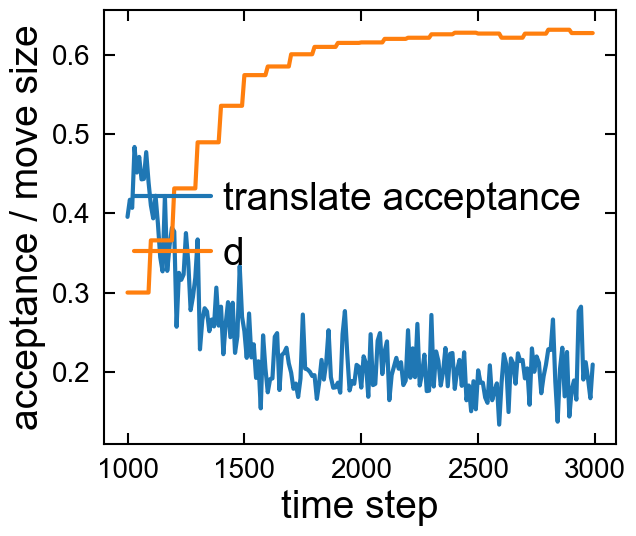

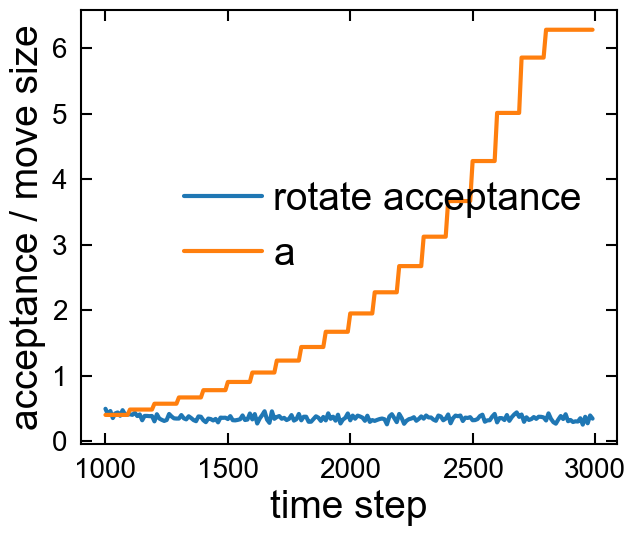

In [9]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
pyplot.figure();
pyplot.plot(data[:,0], data[:,2], label='translate acceptance');
pyplot.plot(data[:,0], data[:,4], label='d');
pyplot.xlabel('time step');
pyplot.ylabel('acceptance / move size');
pyplot.legend();

pyplot.figure();
pyplot.plot(data[:,0], data[:,3], label='rotate acceptance');
pyplot.plot(data[:,0], data[:,5], label='a');
pyplot.xlabel('time step');
pyplot.ylabel('acceptance / move size');
pyplot.legend(loc='right');

We can see above that the translation accept rate acieves 20 % with a move size of 0.6, but the rotational acceptance rate does not quite reach 20 % even with a move size of $2\pi$. Therefore we change the parameters $d$ and $a$ to the best values 0.6 and $2\pi$ and try running a short simulation to observe the performance.

In [10]:
hoomd.context.initialize('--mode=cpu');
#system = hoomd.init.create_lattice(unitcell=hoomd.lattice.fcc(a=3.2), n=[5, 5,5]);
system=deprecated.init.create_random(N=100, phi_p=0.24, min_dist=1.0)

initial_Ly = system.box.Ly;
mc = hoomd.hpmc.integrate.convex_polyhedron(seed=415236, d=0.6, a=2*math.pi)
tetrahedron_verts = [(0.5, 0.5, 0.5), (0.5, -0.5, -0.5), (-0.5, 0.5, -0.5), (-0.5, -0.5, 0.5)]
mc.shape_param.set('A',vertices=tetrahedron_verts);
d = hoomd.dump.gsd("trajectory.gsd",
                   period=10,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(1000,quiet=False);

notice(2): Group "all" created containing 100 particles
** starting run **
Time 00:00:00 | Step 1000 / 1000 | TPS 1076.55 | ETA 00:00:00
Average TPS: 1075.93
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.21201
notice(2): Average rotate acceptance:    0.355371
notice(2): Trial moves per second:        429688
notice(2): Overlap checks per second:     2.20819e+07
notice(2): Overlap checks per trial move: 51.3906
notice(2): Number of overlap errors:      0
** run complete **


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 57 images per trial move, performance may slow.
This message will not be repeated.


The acceptance rates are close to the desired value of 20 %. Now the quick compression scheme can be started with these parameters.

## Compress the system

Set parameters for the compression. 
* **target_phi** is the target packing fraction. 
* **scale_factor** is the factor by which to scale box length on each step.
* **max_trials** is the maximum number of 100 time steps runs to try increasing the packing fraction before exiting. This makes sure that we do not get stuck in infitine loops.

If scale factor is too small, the scale operation may introduce an overlap that even a maximum trial move displacement cannot remove. When this occurs, the overlap will remain indefinitely and the loop will not terminate. The max_trials can be small for test systems which are run on CPU's and can be increased when running on GPUs since the performance is better and we can afford making longer runs.

In [11]:
target_phi = 0.856
scale_factor = 0.995
max_trials = 1000

In [12]:
def quick_compress(system,
                   tetrahedron_volume,
                   target_phi,
                   max_trials,
                   scale_factor):
    d = hoomd.dump.gsd("trajectory-compress.gsd",
                   period=1000,
                   group=hoomd.group.all(),
                   overwrite=True);
    log1 = hoomd.analyze.log(filename="log-output.log",
                         quantities=['lx', 'ly', 'xy', 
                                     'hpmc_overlap_count',
                                     'hpmc_translate_acceptance',
                                     'hpmc_rotate_acceptance'],
                         period=10,
                         overwrite=True);

    N = len(system.particles);
    print('N:',N)
    target_volume = N*tetrahedron_volume / target_phi;
    current_volume = system.box.get_volume();
    print(target_volume,current_volume)
    achieved_densities = []
    time_steps_to_reach_density = []
    while target_volume < current_volume:
        current_volume = max(current_volume*scale_factor, target_volume);
        new_box = system.box.set_volume(current_volume);
        print('new volume:',current_volume)
        hoomd.update.box_resize(Lx=new_box.Lx, Ly=new_box.Ly, Lz=new_box.Lz, period=None);

        overlaps = mc.count_overlaps();
        print("phi =", (N*tetrahedron_volume) / (new_box.get_volume()), ": overlaps =", overlaps, end=' ');

        # run until all overlaps are removed
        num_trials = 0
        while overlaps > 0 and num_trials<max_trials:
            hoomd.run(100, quiet=True);
            overlaps = mc.count_overlaps();
            print(overlaps, end=' ');
            sys.stdout.flush();
            num_trials+=1

        if overlaps > 0:#if we did not get zero overlaps, time to quit.
            break
        achieved_density = N*tetrahedron_volume/current_volume
        achieved_densities.append(achieved_density)
        time_steps_to_reach_density.append(num_trials*100)
        print();
        
    if current_volume<=target_volume:
        print('Reached target volume! Current density:',N*tetrahedron_volume/current_volume)
    else:
        print('Exited shrink loop. number of trials:',num_trials)
        
    return achieved_densities,time_steps_to_reach_density

In [13]:
hoomd.context.initialize('--mode=cpu');
#system = hoomd.init.create_lattice(unitcell=hoomd.lattice.fcc(a=3.2), n=[5, 5,5]);
system=deprecated.init.create_random(N=100, phi_p=0.24, min_dist=1.0)

initial_Ly = system.box.Ly;
mc = hoomd.hpmc.integrate.convex_polyhedron(seed=415236, d=0.6, a=2*math.pi)
tetrahedron_verts = [(0.5, 0.5, 0.5), 
                     (0.5, -0.5, -0.5), 
                     (-0.5, 0.5, -0.5), 
                     (-0.5, -0.5, 0.5)]
mc.shape_param.set('A',vertices=tetrahedron_verts);
d = hoomd.dump.gsd("trajectory.gsd",
                   period=10,
                   group=hoomd.group.all(),
                   overwrite=True);
hoomd.run(1000,quiet=False);


notice(2): Group "all" created containing 100 particles
** starting run **
Time 00:00:01 | Step 1000 / 1000 | TPS 1037.38 | ETA 00:00:00
Average TPS: 1036.59
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.21201
notice(2): Average rotate acceptance:    0.355371
notice(2): Trial moves per second:        414132
notice(2): Overlap checks per second:     2.12825e+07
notice(2): Overlap checks per trial move: 51.3906
notice(2): Number of overlap errors:      0
** run complete **


*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 57 images per trial move, performance may slow.
This message will not be repeated.


In [14]:
rhos,ts_to_zero_overlap = quick_compress(system,
                                         tetrahedron_volume,
                                         target_phi,
                                         max_trials,
                                         scale_factor)

N: 100
38.940809968847354 218.1661564992911
new volume: 217.07532571679465
phi = 0.15355652800826092 : overlaps = 0 
new volume: 215.98994908821066
phi = 0.15432816885252348 : overlaps = 1 0 
new volume: 214.90999934276962
phi = 0.15510368728896834 : overlaps = 1 0 
new volume: 213.83544934605578
phi = 0.15588310280298326 : overlaps = 0 
new volume: 212.7662720993255
phi = 0.15666643497787264 : overlaps = 3 0 
new volume: 211.70244073882887
phi = 0.15745370349534937 : overlaps = 1 0 
new volume: 210.64392853513473
phi = 0.15824492813602947 : overlaps = 3 0 
new volume: 209.59070889245905
phi = 0.15904012877992912 : overlaps = 1 0 
new volume: 208.54275534799675
phi = 0.15983932540696397 : overlaps = 2 0 
new volume: 207.50004157125676
phi = 0.16064253809745124 : overlaps = 0 
new volume: 206.46254136340048
phi = 0.16144978703261428 : overlaps = 1 0 
new volume: 205.43022865658347
phi = 0.16226109249508983 : overlaps = 1 0 
new volume: 204.40307751330056
phi = 0.16307647486943694 : over

phi = 0.26518715411082955 : overlaps = 6 0 
new volume: 125.06890380069215
phi = 0.2665197528752055 : overlaps = 4 0 
new volume: 124.44355928168869
phi = 0.2678590481157845 : overlaps = 0 
new volume: 123.82134148528024
phi = 0.26920507348320055 : overlaps = 3 0 
new volume: 123.20223477785385
phi = 0.27055786279718647 : overlaps = 4 0 
new volume: 122.58622360396457
phi = 0.27191745004742357 : overlaps = 1 0 
new volume: 121.97329248594474
phi = 0.2732838693943956 : overlaps = 3 0 
new volume: 121.36342602351502
phi = 0.27465715517024686 : overlaps = 4 0 
new volume: 120.75660889339744
phi = 0.27603734187964507 : overlaps = 4 0 
new volume: 120.15282584893045
phi = 0.27742446420064826 : overlaps = 4 1 0 
new volume: 119.5520617196858
phi = 0.27881855698557617 : overlaps = 2 0 
new volume: 118.95430141108737
phi = 0.2802196552618855 : overlaps = 1 0 
new volume: 118.35952990403193
phi = 0.28162779423305084 : overlaps = 8 0 
new volume: 117.76773225451177
phi = 0.28304300927944803 : ov

phi = 0.44217913582496976 : overlaps = 10 6 6 5 5 5 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 
new volume: 75.00730807840563
phi = 0.4444011415326327 : overlaps = 12 8 6 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 
new volume: 74.6322715380136
phi = 0.4466343130981234 : overlaps = 8 2 2 1 1 0 
new volume: 74.25911018032353
phi = 0.4488787066312797 : overlaps = 9 5 2 0 
new volume: 73.88781462942191
phi = 0.4511343785238992 : overlaps = 7 4 3 3 3 3 3 2 1 1 1 1 0 
new volume: 73.5183755562748
phi = 0.4534013854511552 : overlaps = 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 
new volume: 73.15078367849343
phi = 0.45567978437302026 : overlaps = 7 4 4 3 1 1 1 1 1 1 1 1 1 1 1 0 
new volume: 72.78502976010095
phi = 0.4579696325356987 : overlaps = 8 7 2 2 2 2 2 1 1 0 
new volume: 72.42110461130045
phi = 0.46027098747306405 : overlaps = 5 5 4 4 4 4 3 3 2 2 1 0 
new volume: 72.05899908824395
phi = 0.46258390700810453 : overlaps = 17 16 12 12 10 6 4 4 3 3 3 2 2 0 
new volume: 71.69870409

phi = 0.537648077864694 : overlaps = 16 16 16 16 15 15 15 15 15 14 13 13 13 13 12 12 12 12 11 11 11 9 9 9 9 9 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 
new volume: 61.68843158221702
phi = 0.5403498269996925 : overlaps = 12 12 12 12 11 11 11 11 11 11 11 10 10 10 10 10 10 10 10 10 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8 8 6 6 6 6 6 6 5 5 5 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

phi = 0.5624583529705369 : overlaps = 23 22 22 22 22 21 20 20 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 15 15 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 12 12 12 12 11 11 11 11 9 9 9 9 9 9 8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 
new volume: 58.96732885466459
phi = 0.5652847768548108 : overlaps = 20 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 17 17 17 17 16 16 16 16 16 16 16 

Based on the log, the maximum packing fraction achieved was 0.57 when only 1e5 trials without removing all overlaps was allowed after a shrink of 0.5 %. 

Now we look at the number of time steps (MC trials) it took for each increment in packing fraction from the initial value of 0.15. The final iteration which took 1e5 trials is not shown here.

No handles with labels found to put in legend.
/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


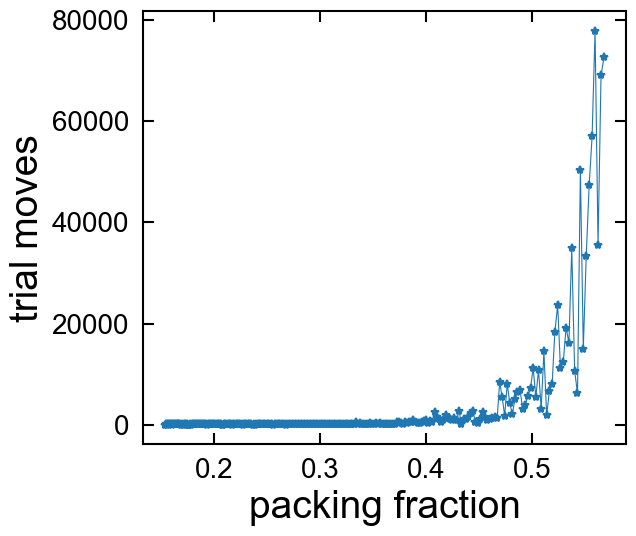

In [15]:
pyplot.figure();
pyplot.plot(rhos, ts_to_zero_overlap,linewidth=0.8,marker='*');
pyplot.xlabel('packing fraction');
pyplot.ylabel('trial moves');
pyplot.legend(loc='right');

The number of time steps to decrease the volume by 0.5 % increases rapidly after a packing fraction of 0.5.

This is seen in the plot below as well.

/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


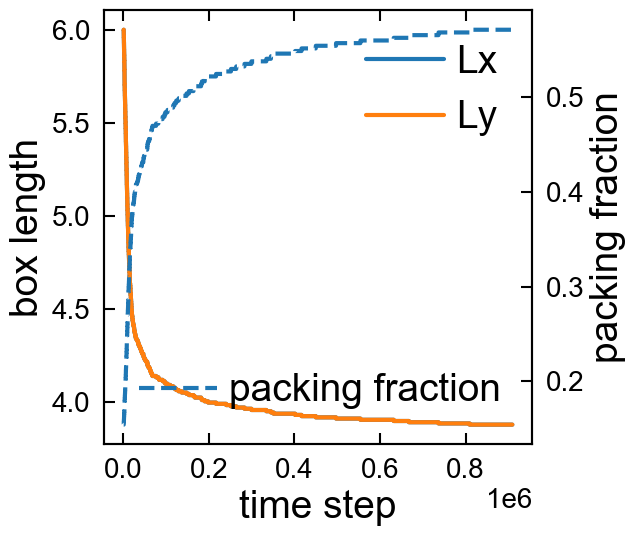

In [16]:
#pyplot.figure()#figsize=(4,2.2), dpi=140);
fig, ax1 = pyplot.subplots()
ax2 = ax1.twinx()
N = len(system.particles);
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
ax1.plot(data[:,0], data[:,1], label='Lx');
ax1.plot(data[:,0], data[:,2], label='Ly');
ax2.plot(data[:,0], 
         N*tetrahedron_volume/(data[:,2]**3), 
         linestyle='--',
         label='packing fraction');
ax1.set_ylabel('box length');
ax1.set_xlabel('time step');
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.legend(loc='best');
ax2.set_ylabel('packing fraction');

ax2.legend(loc='best');

To estimate the number of time steps to run to get to the known highest packing fraction of tetrahedrons using these parameters, we first try a rough approximation using a logarithmic function fitting.

/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log2
  


[ 3.64788212e-02 -1.35970025e-01 -9.84677517e+02]


/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


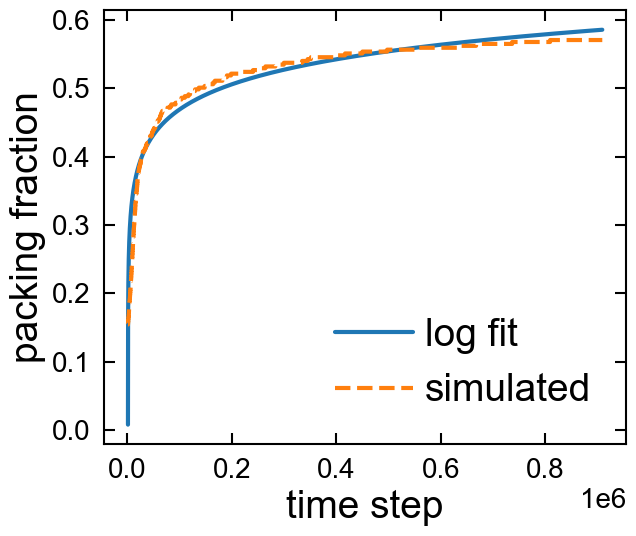

In [17]:
from scipy import interpolate
import numpy as np
from scipy.optimize import curve_fit

def f(x, a, b,c):
    return a*np.log2(c+x)+b

fig, ax1 = pyplot.subplots()

data = numpy.genfromtxt(fname='log-output.log', skip_header=True);
ts = data[:,0]
density = N*tetrahedron_volume/data[:,2]**3


try:
    popt, pcov = curve_fit(lambda Xs,a,b,c: f(Xs,a,b,c),
                           ts,density)#,
                           #p0=[0,0,0],
                           #bounds=([0,0,0],[np.infty,np.infty,np.infty]))
    #print('found fit')
except FloatingPointError:
    print('Curve fitting failed(FloatingPointError)')
except RuntimeError:
    print('Curve fitting failed(RuntimeError)')
except TypeError:
    print('Curve fitting failed(TypeError)')
except ValueError:
    print('Curve fitting failed(ValueError)')
print(popt)  
ydata = np.asarray(density)

fit_ydata = f(ts,*popt)
residuals = ydata - fit_ydata
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)

extrapolate = False
if extrapolate:
    xs = np.linspace(0,1e9,1e6)
    ys = f(xs,*popt)
    ax1.plot(xs, 
         ys, 
         linestyle='-',
         color='r',
         label='extrapolated');
ax1.plot(ts, 
     fit_ydata, 
     linestyle='-',
     label='log fit');
        
ax1.plot(ts, 
         density, 
         linestyle='--',
         label='simulated');

ax1.set_ylabel('packing fraction');
ax1.set_xlabel('time step');
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.legend(loc='best');



The logarithmic function is seen to be approaching higher packing fraction faster than the simulated data. So an extrapolation of the log function is expected to reach higher packing fracion faster. Below we see that we need to run this simulation for atleast $\approx1.5\times10^8$ timesteps to reach the current record packing fraction for regular tetrahedrons of 0.856 ([Chen et al.](https://link.springer.com/article/10.1007%2Fs00454-010-9273-0)) . Given that we get a TPS of about 1000, the underestimated time required to reach a packing fraction of 0.856 is about 5.5 hours. 

/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


153434853.43485343 0.8560000828219492


/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log2
  
/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


/Users/stephenthomas/miniconda3/envs/citrine_challenge/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


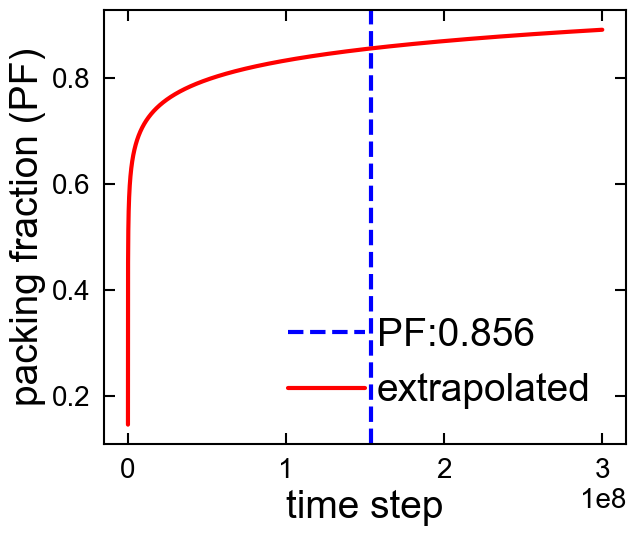

In [18]:
fig, ax1 = pyplot.subplots()
xs = np.linspace(0,3e8,1e6)
ys = f(xs,*popt)
x_i = np.where(ys>=0.856)
index = x_i[0][0]
y = ys[index]
x = xs[index]
print(x,y)
ax1.axvline(x=x,linestyle='--',color='b',label='PF:{}'.format(round(y,3)))
ax1.plot(xs, 
     ys, 
     linestyle='-',
     color='r',
     label='extrapolated');
ax1.set_xlabel('time step')
ax1.set_ylabel('packing fraction (PF)')
ax1.legend()

# Conclusions

* Translation move sizes ($d$) have a higher impact of acceptance rate than rotate move size ($a$).
* The number of trials required to remove all overlaps increase after $\phi\approx0.5$.
* This simple compression scheme where only $1\times10^{5}$ trial moves are allowed before stopping trials only yields a $\phi=0.57$ which is significantly lower than the known limit.
* By fitting the packing fraction data to a logarithmic function, the time to reach $\phi = 0.856$ is estimated to be $\approx 5.5 hours$.
* It is however not clear if this trend will continue with this simple compression scheme where the particle positions are simply scaled into the shrunk box.
* A more sophisticated compression scheme is available in HOOMD's hpmc module and is called "hoomd.hpmc.update.boxmc". This scheme needs to be explored in detail to understand its implications.
* It will be a fruitful exercise to implement polyhedra rendering in the fresnel library so that the tetrahedron packing can be visualized within jupyter notebooks. Currently it is not possible to visualize polyhedra using VMD.